In [50]:
# Cell 1: imports and load
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset that you saved earlier
df = pd.read_csv('../data/clean_youtube_data.csv')
df.head()


,trending_date,publish_time,views,comments_disabled,ratings_disabled,video_error_or_removed,title_length,desc_length,tag_count,publish_hour,...,category_id_20,category_id_22,category_id_23,category_id_24,category_id_25,category_id_26,category_id_27,category_id_28,category_id_29,category_id_43
0,17.14.11,2017-11-13 17:13:01+00:00,748374,False,False,False,34,1410,1,17,...,False,True,False,False,False,False,False,False,False,False
1,17.14.11,2017-11-13 07:30:00+00:00,2418783,False,False,False,62,630,4,7,...,False,False,False,True,False,False,False,False,False,False
2,17.14.11,2017-11-12 19:05:24+00:00,3191434,False,False,False,53,1181,23,19,...,False,False,True,False,False,False,False,False,False,False
3,17.14.11,2017-11-13 11:00:04+00:00,343168,False,False,False,32,1407,27,11,...,False,False,False,True,False,False,False,False,False,False
4,17.14.11,2017-11-12 18:01:41+00:00,2095731,False,False,False,24,636,14,18,...,False,False,False,True,False,False,False,False,False,False


In [51]:

# Ensure 'views' exists and is the target
assert 'views' in df.columns, "Target 'views' not found in dataframe."

# Separate features and target
X = df.drop('views', axis=1)
y = df['views']

# Keep only numeric columns 
X = X.select_dtypes(include=['int64', 'float64', 'uint8'])

# Inspect shapes
print("X shape:", X.shape)
print("y shape:", y.shape)
X.columns[:30]  # show first few feature names


X shape: (40949, 6)
y shape: (40949,)


Index(['title_length', 'desc_length', 'tag_count', 'publish_hour',
       'publish_day', 'publish_month'],
      dtype='object')

In [52]:
# train and split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (32759, 6) Test size: (8190, 6)


In [53]:
# training plain Linear Regression 
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print("Linear Regression")
print(" R2:", r2_score(y_test, lr_pred))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))


Linear Regression
 R2: 0.007113005323896138
 RMSE: 6914383.661895409


In [54]:
#  Ridge and Lasso with StandardScaler in pipeline
ridge_pipe = make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42))
lasso_pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.1, random_state=42, max_iter=10000))

ridge_pipe.fit(X_train, y_train)
lasso_pipe.fit(X_train, y_train)

ridge_pred = ridge_pipe.predict(X_test)
lasso_pred = lasso_pipe.predict(X_test)

print("Ridge Regression")
print(" R2:", r2_score(y_test, ridge_pred))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, ridge_pred)))
print()
print("Lasso Regression")
print(" R2:", r2_score(y_test, lasso_pred))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, lasso_pred)))


Ridge Regression
 R2: 0.007113079633313202
 RMSE: 6914383.403153059

Lasso Regression
 R2: 0.007113006244704123
 RMSE: 6914383.658689194


In [55]:
results

,Model,R2,RMSE
0,LinearRegression,0.007113,6.914384e+06
1,Ridge (alpha=1.0),0.007113,6.914383e+06
2,Lasso (alpha=0.1),0.007113,6.914384e+06


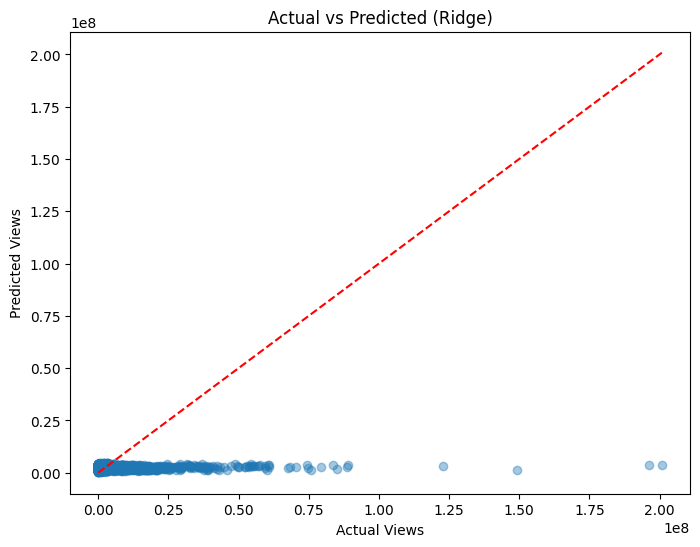

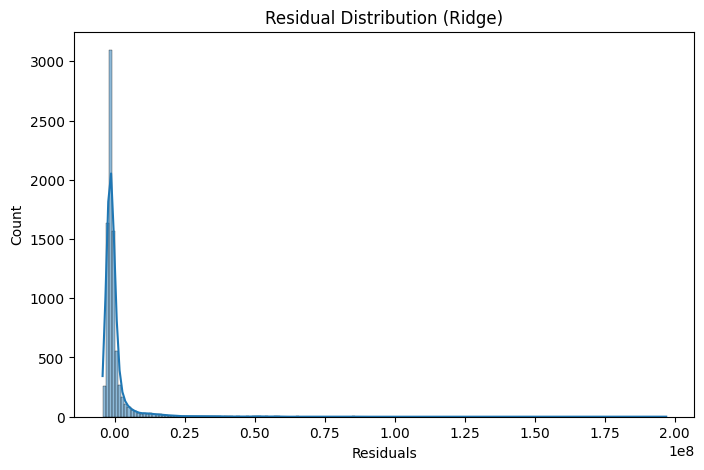

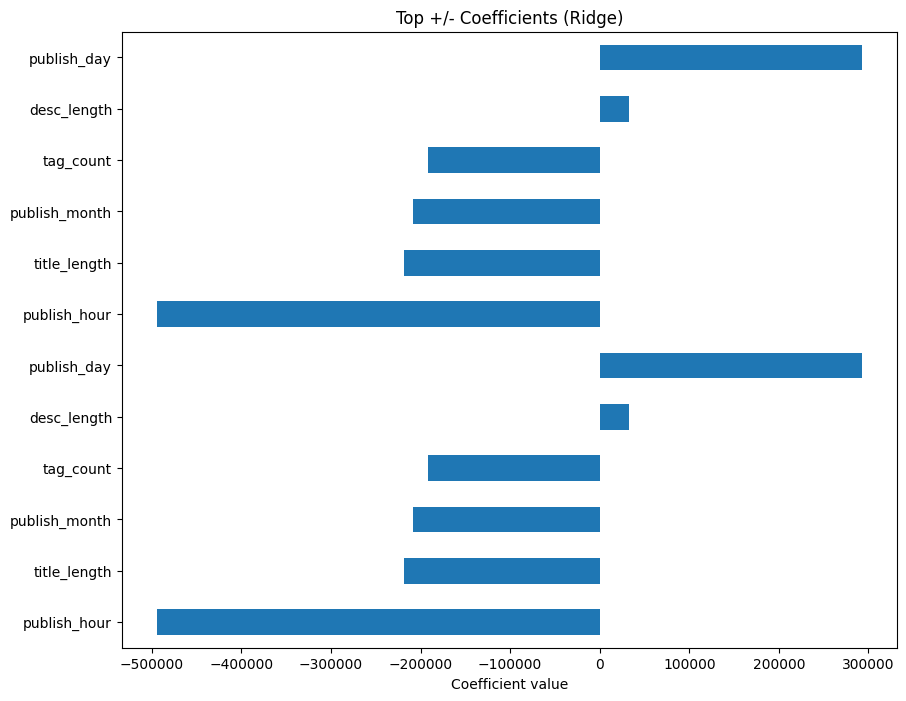

In [56]:
#  visualizations


models = {
    "Linear": (lr, lr_pred),
    "Ridge": (ridge_pipe, ridge_pred),
    "Lasso": (lasso_pipe, lasso_pred)
}

# 1) Actual vs Predicted 
plt.figure(figsize=(8,6))
plt.scatter(y_test, ridge_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("Actual vs Predicted (Ridge)")
plt.show()

# 2) Residual distribution (Ridge)
residuals = y_test - ridge_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Ridge)")
plt.xlabel("Residuals")
plt.show()

# 3) Feature importance (coefficients) - for linear/regression with same feature names
# For Ridge/LR we can extract coefficients; for pipelines get last step coef_
def get_coeffs(model, name):
    if hasattr(model, "coef_"):
        coef = model.coef_
    else:
        # pipeline: last step
        coef = model.named_steps[list(model.named_steps.keys())[-1]].coef_
    return pd.Series(coef, index=X.columns).sort_values()

# Show top 20 positive and negative coefficients for Ridge
ridge_coefs = get_coeffs(ridge_pipe, "Ridge")
top_pos = ridge_coefs.tail(20)
top_neg = ridge_coefs.head(20)

plt.figure(figsize=(10,8))
pd.concat([top_pos, top_neg]).plot(kind='barh')
plt.title("Top +/- Coefficients (Ridge)")
plt.xlabel("Coefficient value")
plt.show()


In [57]:
# save models & results
import joblib
joblib.dump(lr, "../models/linear_regression.pkl")
joblib.dump(ridge_pipe, "../models/ridge_pipeline.pkl")
joblib.dump(lasso_pipe, "../models/lasso_pipeline.pkl")

# Save the results table
results.to_csv("../data/model_results.csv", index=False)

print("Saved models in ../models/ and results in ../data/")


Saved models in ../models/ and results in ../data/


In [58]:
# : Lasso sparse features
lasso_coefs = get_coeffs(lasso_pipe, "Lasso")
nonzero = lasso_coefs[lasso_coefs != 0].sort_values()
print("Number of non-zero coefficients (Lasso):", (lasso_coefs != 0).sum())
display(nonzero.tail(20))


Number of non-zero coefficients (Lasso): 6


publish_hour    -494159.570370
title_length    -218135.556383
publish_month   -208622.932934
tag_count       -191242.719501
desc_length       32676.766490
publish_day      292364.810823
dtype: float64

In [59]:
#  save actual vs predicted (Ridge)
pred_df = pd.DataFrame({
    "actual_views": y_test,
    "pred_views_ridge": ridge_pred,
    "pred_views_lasso": lasso_pred,
    "pred_views_lr": lr_pred
})
pred_df.to_csv("../data/predictions_test_set.csv", index=True)
pred_df.head()


,actual_views,pred_views_ridge,pred_views_lasso,pred_views_lr
15632,206028,3.108188e+06,3.108207e+06,3.108207e+06
40759,402418,1.923632e+06,1.923618e+06,1.923618e+06
10536,1437372,1.974626e+06,1.974610e+06,1.974610e+06
11029,417790,2.121935e+06,2.121925e+06,2.121925e+06
8202,816662,1.784206e+06,1.784194e+06,1.784194e+06
